#Carga de los datos

In [1]:
#-- Descomprimimos el dataset
!rm -r mnist
!unzip mnist.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/

In [19]:
#-- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

992

In [8]:
#-- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

In [9]:
#-- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [10]:
#-- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [12]:
#-- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#Primera parte

## Ahora realizaremos la filtración de los datos de testeo según diversos porcentajes

### 10%

In [26]:
#-- Sacamos la cantidad total de datos y filtramos el 10%
n = len(X_train)
X_train10 = X_train[:int(0.1*n)]
Y_train10 = Y_train[:int(0.1*n)]

In [28]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train10 = Variable(torch.from_numpy(np.array(X_train10))).float()
Y_train10 = Variable(torch.from_numpy(np.array(Y_train10))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train10.data.size()

torch.Size([600, 28, 28])

In [33]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [34]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train10.view(X_train10.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train10)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train10,Y_pred, average='macro') )
  
  acc = sum(Y_train10 == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

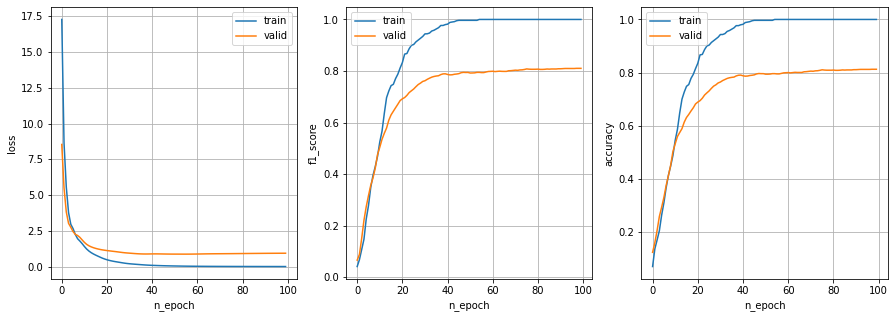

In [35]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [36]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.8574363589286804, f1: 0.8200323291951926, acc: 0.8205645084381104


### 20%

In [37]:
#-- Sacamos la cantidad total de datos y filtramos el 20%
n = len(X_train)
X_train20 = X_train[:int(0.2*n)]
Y_train20 = Y_train[:int(0.2*n)]

In [38]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train20 = Variable(torch.from_numpy(np.array(X_train20))).float()
Y_train20 = Variable(torch.from_numpy(np.array(Y_train20))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train20.data.size()

torch.Size([1200, 28, 28])

In [39]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [40]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train20.view(X_train20.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train20)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train20,Y_pred, average='macro') )
  
  acc = sum(Y_train20 == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

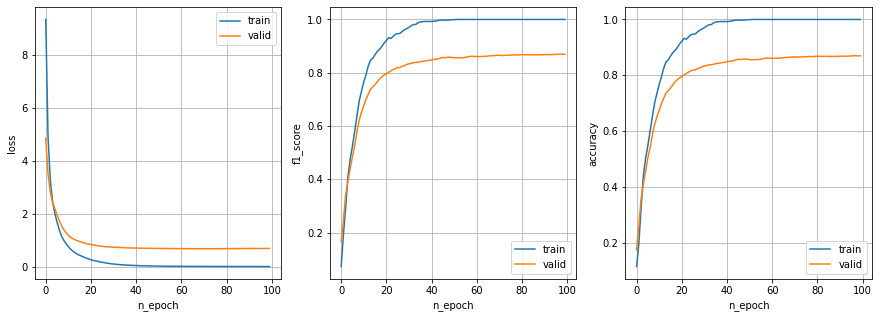

In [41]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [42]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.6328786611557007, f1: 0.855047939063591, acc: 0.8568548560142517


### 50%

In [46]:
#-- Sacamos la cantidad total de datos y filtramos el 50%
n = len(X_train)
X_train50 = X_train[:int(0.5*n)]
Y_train50 = Y_train[:int(0.5*n)]

In [47]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train50 = Variable(torch.from_numpy(np.array(X_train50))).float()
Y_train50 = Variable(torch.from_numpy(np.array(Y_train50))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train50.data.size()

torch.Size([3000, 28, 28])

In [48]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [49]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train50.view(X_train50.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train50)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train50,Y_pred, average='macro') )
  
  acc = sum(Y_train50 == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

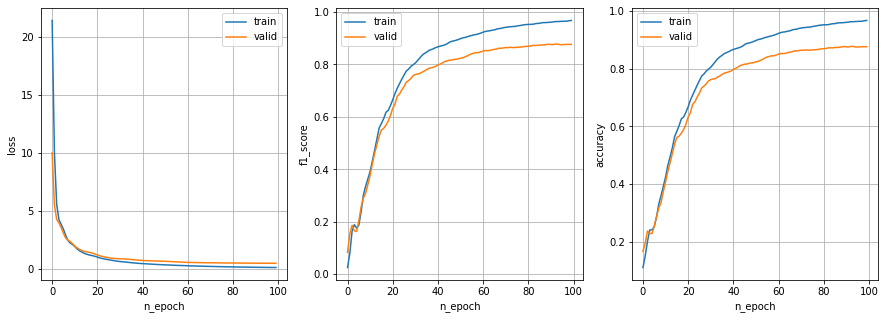

In [50]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [51]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.40561002492904663, f1: 0.8834449497484504, acc: 0.8840726017951965


### 80%

In [52]:
#-- Sacamos la cantidad total de datos y filtramos el 80%
n = len(X_train)
X_train80 = X_train[:int(0.8*n)]
Y_train80 = Y_train[:int(0.8*n)]

In [53]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train80 = Variable(torch.from_numpy(np.array(X_train80))).float()
Y_train80 = Variable(torch.from_numpy(np.array(Y_train80))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train80.data.size()

torch.Size([4800, 28, 28])

In [54]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [55]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train80.view(X_train80.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train80)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train80,Y_pred, average='macro') )
  
  acc = sum(Y_train80 == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

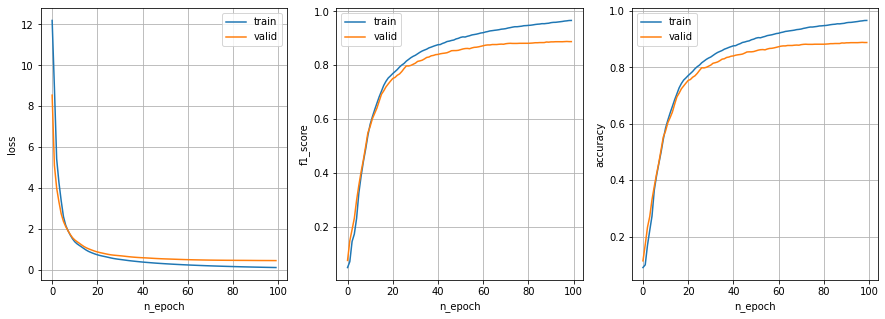

In [56]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [57]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.38489341735839844, f1: 0.8976012040640275, acc: 0.8981854915618896


### 100%

In [63]:
#-- Utilizamos la cantidad total de datos y convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [64]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [65]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

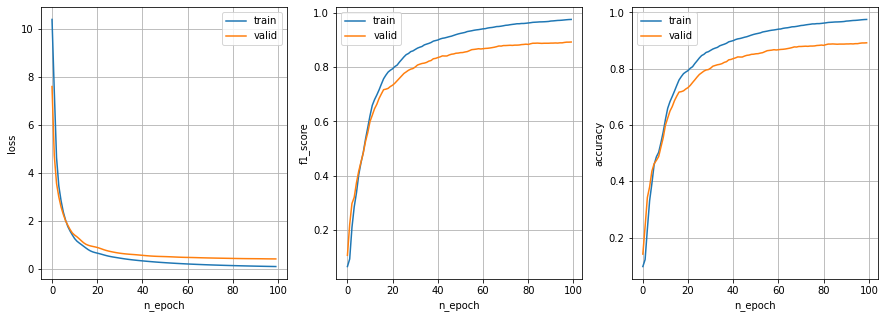

In [66]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [67]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3662063777446747, f1: 0.897559679601326, acc: 0.8981854915618896


#### Podemos notar que a medida que los datos de entrenamiento aumentan, los 3 scores del test de testeo se acercan cada vez más a 1, por lo que es fácil concluir que a mayor cantidad de datos de entrenamiento, y mientras estos no se crucen con los otros, mejor quedará entrenado nuestra red neuronal.

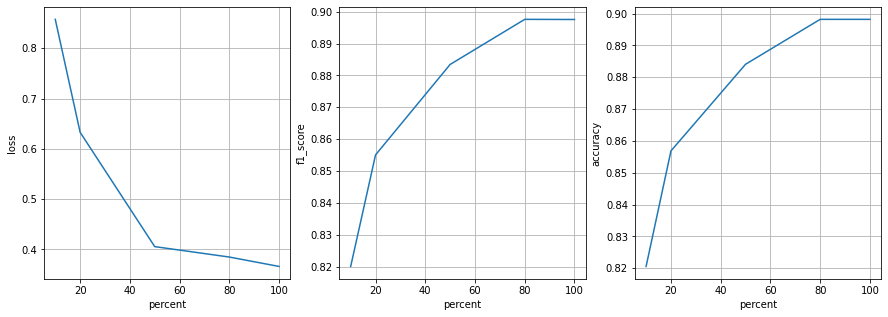

In [106]:
#-- Visualizamos los scores

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([10,20,50,80,100], [0.8574363589286804, 0.6328786611557007, 0.40561002492904663, 0.38489341735839844, 0.3662063777446747])
plt.xlabel('percent')
plt.ylabel('loss')

plt.grid()
plt.subplot(1,3,2)
plt.plot([10,20,50,80,100], [0.8200323291951926, 0.855047939063591, 0.8834449497484504, 0.8976012040640275, 0.897559679601326])
plt.xlabel('percent')
plt.ylabel('f1_score')

plt.grid()
plt.subplot(1,3,3)
plt.plot([10,20,50,80,100], [0.8205645084381104, 0.8568548560142517, 0.8840726017951965, 0.8981854915618896, 0.8981854915618896])
plt.xlabel('percent')
plt.ylabel('accuracy')
plt.grid()

plt.show()

#Segunda Parte

## Ahora realizaremos la filtración de los datos de testeo según diversos porcentajes

### 10%

In [68]:
#-- Sacamos la cantidad total de datos y filtramos el 10%
n = len(X_test)
X_test10 = X_test[:int(0.1*n)]
Y_test10 = Y_test[:int(0.1*n)]

In [70]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test10 = Variable(torch.from_numpy(np.array(X_test10))).float()
Y_test10 = Variable(torch.from_numpy(np.array(Y_test10))).long()

X_test10.data.size()

torch.Size([99, 28, 28])

In [71]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [72]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

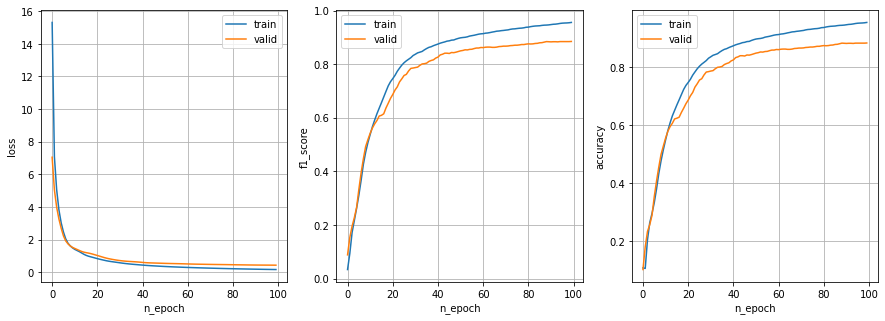

In [73]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [74]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test10.view(X_test10.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test10)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test10, Y_pred, average='macro')

acc = sum(Y_test10 == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.2959446907043457, f1: 0.8905078873654727, acc: 0.8888888955116272


### 20%

In [75]:
#-- Sacamos la cantidad total de datos y filtramos el 20%
n = len(X_test)
X_test20 = X_test[:int(0.2*n)]
Y_test20 = Y_test[:int(0.2*n)]

In [76]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test20 = Variable(torch.from_numpy(np.array(X_test20))).float()
Y_test20 = Variable(torch.from_numpy(np.array(Y_test20))).long()

X_test20.data.size()

torch.Size([198, 28, 28])

In [77]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [78]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

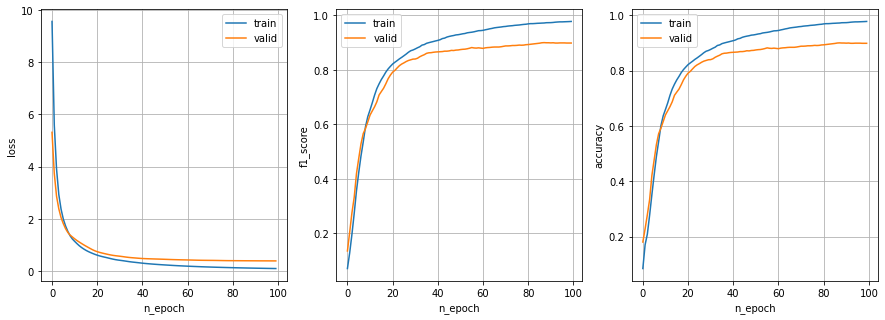

In [79]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [80]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test20.view(X_test20.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test20)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test20, Y_pred, average='macro')

acc = sum(Y_test20 == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.29410266876220703, f1: 0.9050950173553627, acc: 0.9040403962135315


### 50%

In [84]:
#-- Sacamos la cantidad total de datos y filtramos el 50%
n = len(X_test)
X_test50 = X_test[:int(0.5*n)]
Y_test50 = Y_test[:int(0.5*n)]

In [85]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test50 = Variable(torch.from_numpy(np.array(X_test50))).float()
Y_test50 = Variable(torch.from_numpy(np.array(Y_test50))).long()

X_test50.data.size()

torch.Size([496, 28, 28])

In [86]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [87]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

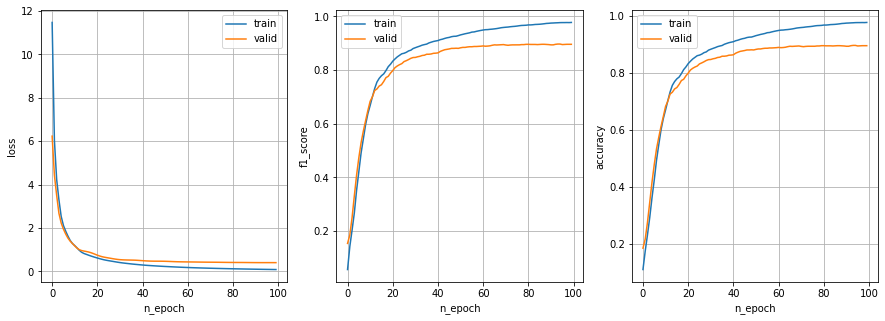

In [88]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [89]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test50.view(X_test50.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test50)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test50, Y_pred, average='macro')

acc = sum(Y_test50 == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.28706857562065125, f1: 0.9124548854295276, acc: 0.9112903475761414


### 80%

In [91]:
#-- Sacamos la cantidad total de datos y filtramos el 10%
n = len(X_test)
X_test80 = X_test[:int(0.8*n)]
Y_test80 = Y_test[:int(0.8*n)]

In [92]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test80 = Variable(torch.from_numpy(np.array(X_test80))).float()
Y_test80 = Variable(torch.from_numpy(np.array(Y_test80))).long()

X_test80.data.size()

torch.Size([793, 28, 28])

In [93]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [94]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

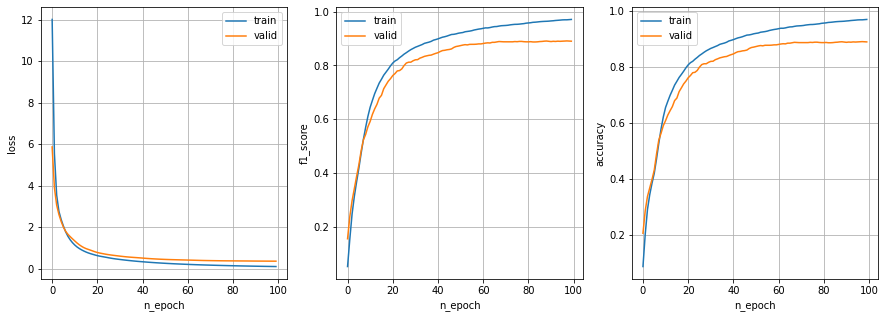

In [95]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [96]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test80.view(X_test80.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test80)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test80, Y_pred, average='macro')

acc = sum(Y_test80 == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3106129765510559, f1: 0.9074419548895996, acc: 0.9066835045814514


### 100%

In [97]:
#--- Utilizamos la cantidad total de datos de testeo y convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_test.data.size()

torch.Size([992, 28, 28])

In [98]:
#--- Definimos una ANN con tres capas ocultas lineales de 50 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),    
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [99]:
#Y entrenamos nuestro modelo
from sklearn.metrics import f1_score 

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

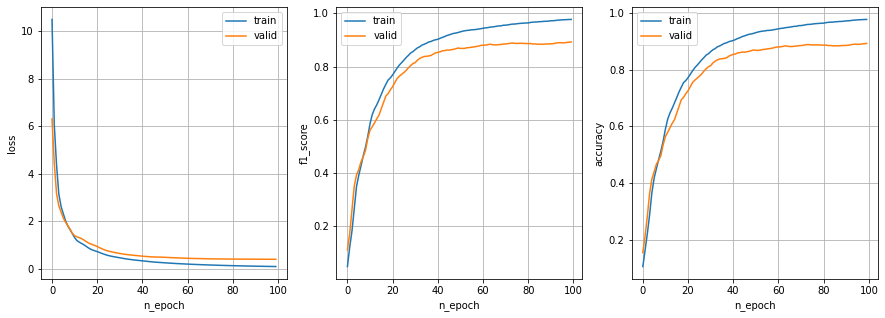

In [100]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [101]:
#-- Y finalmente evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3476121723651886, f1: 0.9021136903248047, acc: 0.9022177457809448


#### Por este lado, podremos ahora notar que a medida que los datos de testeo aumentan, los 3 scores del test de testeo se acercan cada vez más a su convergencia (en este caso, cercana a 0.90), por lo que se concluye que a mayor cantidad de datos de testeo, y mientras estos no se crucen con los otros, la información que los dará los 3 scores será más precisa y mostrará con mejor fiabilidad qué tan buena es nuestra red neuronal.

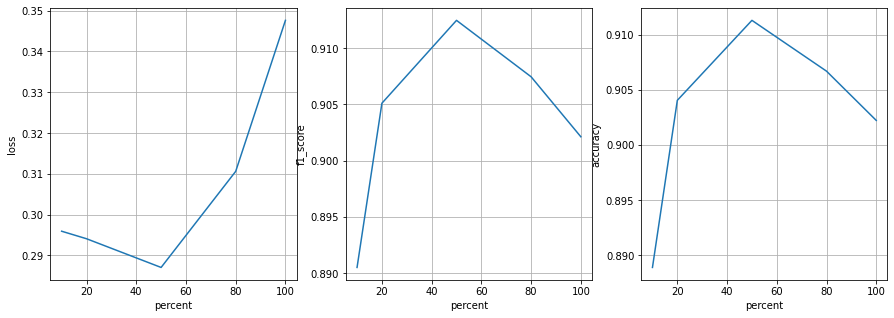

In [105]:
#-- Visualizamos los scores

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([10,20,50,80,100], [0.2959446907043457, 0.29410266876220703, 0.28706857562065125, 0.3106129765510559, 0.3476121723651886])
plt.xlabel('percent')
plt.ylabel('loss')

plt.grid()
plt.subplot(1,3,2)
plt.plot([10,20,50,80,100], [0.8905078873654727, 0.9050950173553627, 0.9124548854295276, 0.9074419548895996, 0.9021136903248047])
plt.xlabel('percent')
plt.ylabel('f1_score')

plt.grid()
plt.subplot(1,3,3)
plt.plot([10,20,50,80,100], [0.8888888955116272, 0.9040403962135315, 0.9112903475761414, 0.9066835045814514, 0.9022177457809448])
plt.xlabel('percent')
plt.ylabel('accuracy')
plt.grid()

plt.show()